## Produce R(Q) from R(WaveLength, Two_Theta) for variable Two_Theta in fixed wavelength bins [Batch Mode]

Version 1.1

09.15.2020

M.R. Fitzsimmons

10.07.2020 Documentation added.



## User selects run files to assemble.
Must run CW_reduction_batch first to produce the background subtracted binned R(WaveLength, Two_Theta) files.

    1) Assign directory path. Code will search directory for output files from the CW_reduction... notebook.
    2) Identify run numbers to assemble (run numbers correspond to different two_theta values)
    3) Choose constant Q bins or logarthimic Q bins and size of bins.
    4) Set signal threshold below which data will not be used.
    5) Choose whether or not to apply phase space brightness correction.


In [76]:
# Suppress autoscrolling in notebook, otherwise try Cell>All Output>Toggle Scrolling
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

import os
%cd ~
cwd_path = os.getcwd()
print('Current working directory: %s'%cwd_path)

directory_path = cwd_path+r'/Dropbox (ORNL)/Neutron Scattering/CW Approach/ForGitHub/' # USER INPUT HERE
Output_File_Base = directory_path+'RvsQ' 

run_numbers = ['36563','-','36662'] # USER INPUT HERE, the run numbers batch8 eric

#LogBin = False # USER INPUT HERE Specify whether to produce Qbins of constant size (=False)
LogBin = True # USER INPUT HERE Specify whether to apply log binning of Qbins (= True)

if LogBin:
    rel_dQ = 0.01 #  USER INPUT HERE Q bins such that dQ/Q = rel_dQ
else:
    abs_dQ = 0.05 #  USER INPUT HERE Q bins of constant size such that dQ = abs_dLQ * Qmin
    
# USER INPUT HERE, if true This is an absolute number below which data will be discarded, could be 0 to suppress.
# If False will use fractional definition

UserSignalThreshold = False 
#UserSignalThreshold = True 

SignalThreshold = 0.5 # USER INPUT HERE By default all data < SignalThreshold*distribution average will be discarded, e.g., proton flash zeros
if UserSignalThreshold:
    SignalThreshold = 10000. 
    
# Data were taken ensuring the sample was over-illuminated for all 2theta, brightness increases as theta^2
# USER INPUT HERE, true if sample was at least somewhat over-illuminated and slit opened with theta

PhaseSpaceBrightness = True 
#PhaseSpaceBrightness = False

# Set for True to execute diagnostic inspections (in this section define which wavelength bins to inspect)
Diagnostic = False
#Diagnostic = True

/Users/mf3
Current working directory: /Users/mf3


## Import libraries and define functions

In [77]:
import numpy as np
import numpy.ma as ma 
from numpy.linalg import inv
np.warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.colors as colors
import scipy.optimize as opt
import scipy.constants 
import copy
from datetime import datetime

# get physical constants from scipy library
Pi = scipy.constants.pi


## Begin processing of many files

In [78]:
# This bit of code will check whether the user defined a range with the '-' symbol. If so create a continuous range of run numbers
if any('-' in s for s in run_numbers):
    i,j = int(run_numbers[0]),int(run_numbers[len(run_numbers)-1])
    if j<i:
        j,i = i,j
    run_numbers = []
    for k in range(i,j+1,1):
        run_numbers.append(str(k))
MaxRunNumber = len(run_numbers)

# Check for valid files, elimnate choices that are not valid
RunNumbers = []
for RunIndex in range(MaxRunNumber):
    Input_File_Base = directory_path+run_numbers[RunIndex]+'_output' 
    data_is = os.path.isfile(Input_File_Base+'.txt')
    if data_is:
        RunNumbers.append(str(run_numbers[RunIndex]))
    else:
        print('Data files not found: %s'%Input_File_Base)
        raise SystemExit('Files not found, stopping.')

print('Runs found: %s'%RunNumbers)
MaxRunNumber = len(RunNumbers)

for RunIndex in range(MaxRunNumber):
    
    Input_File_Base = directory_path+RunNumbers[RunIndex]+'_output' 
    File_object = open(Input_File_Base+'.txt','r') # Load some data
    a = File_object.readlines()
    
# AllData will contain the signal data vs. variable wavelength vs. number of two_theta steps
    if (RunIndex == 0):        
        NWaveLength = len(a)
        AllData = np.zeros((NWaveLength,5,MaxRunNumber), dtype=np.float32)
        
    for i in range(NWaveLength):
        floats = [float(x) for x in a[i].split('\t')]
        AllData[i,0,RunIndex] = floats[0] # wavelength in angstroms
        AllData[i,1,RunIndex] = floats[1] # 2theta in radians
        AllData[i,2,RunIndex] = floats[2] # signal
        AllData[i,3,RunIndex] = floats[3] # variance
        AllData[i,4,RunIndex] = 4*Pi*np.sin(AllData[i,1,RunIndex]/2)/AllData[i,0,RunIndex] # Q in recip Angstroms
    File_object.close()
    
# Check that all two_theta steps have the same wavelength range and steps

WaveLength = AllData[:,0,0] # we assume the list of wavelengths for the first file defines the range and steps
for RunIndex in range(MaxRunNumber):
    g = np.sum(AllData[:,0,RunIndex]-WaveLength)
    if (g != 0): # Report a mismatch
        print('Error: Wavelength mismatch. %s'%(RunNumbers[RunIndex]))

# for fixed first entry (wavelength) the last three columns of AllData provide S(Q), Var(Q) and Q

Runs found: ['36563', '36564', '36565', '36566', '36567', '36568', '36569', '36570', '36571', '36572', '36573', '36574', '36575', '36576', '36577', '36578', '36579', '36580', '36581', '36582', '36583', '36584', '36585', '36586', '36587', '36588', '36589', '36590', '36591', '36592', '36593', '36594', '36595', '36596', '36597', '36598', '36599', '36600', '36601', '36602', '36603', '36604', '36605', '36606', '36607', '36608', '36609', '36610', '36611', '36612', '36613', '36614', '36615', '36616', '36617', '36618', '36619', '36620', '36621', '36622', '36623', '36624', '36625', '36626', '36627', '36628', '36629', '36630', '36631', '36632', '36633', '36634', '36635', '36636', '36637', '36638', '36639', '36640', '36641', '36642', '36643', '36644', '36645', '36646', '36647', '36648', '36649', '36650', '36651', '36652', '36653', '36654', '36655', '36656', '36657', '36658', '36659', '36660', '36661', '36662']


## Exclude low signal regions
These regions occur either because they are coincident with the proton flash or chopper shadows.

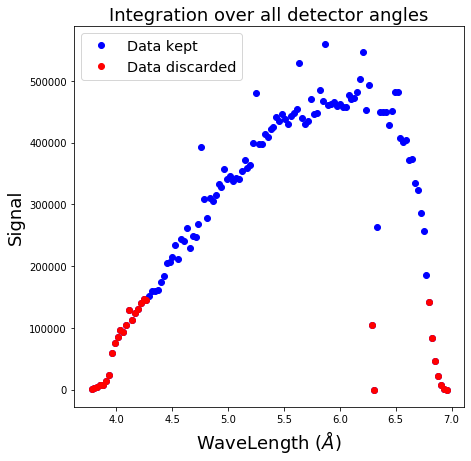

Number of wavelength bins: 95
Time of flight gain for 2% wavelength resolution: 22.5


In [79]:
WaveLengthProjection = np.zeros(NWaveLength, dtype=np.float32)
for i in range(NWaveLength):
    WaveLengthProjection[i] = np.sum(AllData[i,2,:])

# Initialize values to true
SignalMask = np.array([True for i in range(NWaveLength)] )

if not UserSignalThreshold:
    SignalThreshold = SignalThreshold * np.mean(WaveLengthProjection)

SignalMask[WaveLengthProjection < SignalThreshold] = False

Masked = np.argwhere(SignalMask==False)

plt.figure(figsize = (7,7))
plt.xlabel('WaveLength ($\AA$)',fontsize=18)
plt.ylabel('Signal',fontsize=18)
plt.title('Integration over all detector angles',fontsize=18)
plt.plot(AllData[:,0,0],WaveLengthProjection, 'bo',label = 'Data kept')
plt.plot(AllData[Masked,0,0],WaveLengthProjection[Masked], 'ro', label = 'Data discarded')
plt.legend(loc='upper left', fontsize='x-large')
plt.show()

# Now remove the exclude regions
AllData = np.delete(AllData, Masked, axis=0)
TOFGain = int(len(AllData[:,0,0]))
print('Number of wavelength bins: %s'%TOFGain)

# Assign conventional labels
WaveLength = AllData[:,0,:]
TwoTheta = AllData[:,1,:]
Q = AllData[:,4,:]
R = AllData[:,2,:]
VarR = AllData[:,3,:]

if PhaseSpaceBrightness:
    R = R / (TwoTheta/2)**2
    VarR = VarR / (TwoTheta/2)**4
    
print('Time of flight gain for 2%% wavelength resolution: %.1f'%((np.max(WaveLength[:,0])-np.min(WaveLength[:,0]))/(np.mean(WaveLength[:,0]) * 0.02)))

# Check for negative values, if found reset R and VarR to 0.
NegativeR = np.argwhere(R<0)
NNeg = len(NegativeR)
if NNeg > 0:    
    for i in range(NNeg):
        R[NegativeR[i,0],NegativeR[i,1]] = 0.
        VarR[NegativeR[i,0],NegativeR[i,1]] = 0.


## Diagnostic inspection
Set values for u and v to be small to large wavelength bin numbers. Analysis restricted to bins within these limits.

In [80]:
if Diagnostic:
# pick subset for diagnostics
    u,v = 40, 55
    WaveLength = WaveLength[u:v,:]
    TwoTheta = TwoTheta[u:v,:]
    Q = Q[u:v,:]
    R = R[u:v,:]
    VarR = VarR[u:v,:]

    TOFGain = v-u  
    
    plt.figure(figsize = (7,7))
    plt.xlabel('Q ($\AA$\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE})',fontsize=18)
    plt.ylabel('Signal',fontsize=18)
    plt.title('Many R curves (zeros suppressed)',fontsize=18)
    plt.yscale('log')
    for i in range(TOFGain):
        Masked = np.argwhere(R[i,:]>0)
        x = Q[i,Masked]
        y = R[i,Masked]
        plt.plot(x,y)
    plt.show()

## Normalize curves to have same signal in the same shared region of Q.
In the region of Q shared by all curves, the curves should look the same except for scaling.

    1) Find the region of Q that is shared by all wavelength bins. 
    2) Compute integrated intensities for each bin and scale signal and variance accordingly
    3) Plot the integrated intensities vs. wavelength

Q-overlap region: 0.019123752, 0.16020207


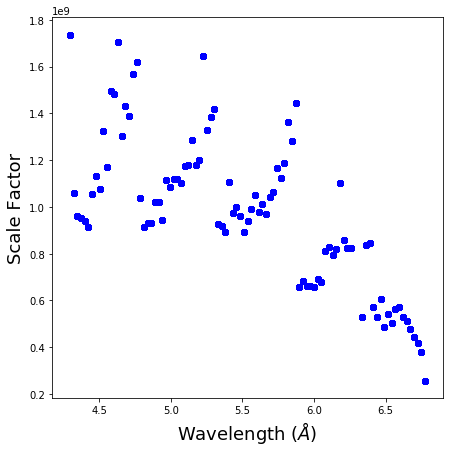

In [81]:
# find Q overlap region for all curves
QOverMin, QOverMax = np.min(Q[0,:]), np.max(Q[TOFGain-1,:])

print('Q-overlap region: %s, %s'%(QOverMin, QOverMax))

Scales = np.zeros(TOFGain,dtype=np.float32)
for i in range(TOFGain):
    b = Q[i,:] <= QOverMax
    c = Q[i,:] >= QOverMin
    d = b & c
    Scales[i] = np.sum(R[i,d]) * (QOverMax-QOverMin) / (np.max(Q[i,d])-np.min(Q[i,d]))
    R[i,:] = R[i,:] / Scales[i]
    VarR[i,:] = VarR[i,:] / Scales[i]**2
    
plt.figure(figsize = (7,7))
plt.xlabel('Wavelength ($\AA$)',fontsize=18)
plt.ylabel('Scale Factor',fontsize=18)
plt.plot(WaveLength,Scales,'bo')
plt.show()

QSum = np.sum(Q,axis=0)/TOFGain # these for crude comparison
RSum = np.sum(R,axis=0)/TOFGain
VarRSum = np.sum(VarR,axis=0)/TOFGain**2


In [82]:
if Diagnostic:
    plt.figure(figsize = (7,7))
    plt.xlabel('Q ($\AA$\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE})',fontsize=18)
    plt.ylabel('Signal',fontsize=18)
    plt.title('Many R curves after scaling (zeros suppressed)',fontsize=18)
    plt.yscale('log')
    for i in range(TOFGain):
        Masked = np.argwhere(R[i,:]>0)
        x = Q[i,Masked]
        y = R[i,Masked]
        plt.plot(x,y)
    plt.show()

## Perform contant Q binning across all wavelength measurements

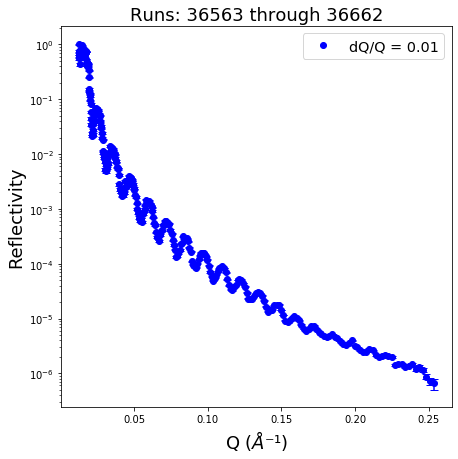

In [83]:
QMin, QMax = np.min(Q), np.max(Q)

if LogBin:
    p = int(np.log(QMax/QMin)/np.log(1+rel_dQ)+1)+1
    QBins = np.zeros(p, dtype=np.float32)
    for i in range(p):
        QBins[i]=(1+rel_dQ)**i*QMin # tof values for start of each bin
else:
    p = int((QMax-QMin)/(abs_dQ*QMin)+1)+1
    QBins = np.linspace(QMin,QMax,p)

Qz = np.zeros(p-1, dtype=np.float32)
R0 = np.zeros(p-1, dtype=np.float32)
VarR0 = np.zeros(p-1, dtype=np.float32)

for j in range(p-1):
    Qz[j] = (QBins[j]+QBins[j+1])/2. # qz value for the mean of the bin
    k = 0 # k records the number of contributions to R(Qz)
    for i in range(TOFGain):
        b = Q[i,:] <= QBins[j+1]
        c = Q[i,:] > QBins[j]
        d = b & c
        if np.sum(d)>0 and np.sum(R[i,d])>0:
            k = k + np.sum(d)
            R0[j] = R0[j] + np.sum(R[i,d])
            VarR0[j] = VarR0[j] + np.sum(VarR[i,d])
    if k != 0:
        R0[j] = R0[j] / k
        VarR0[j] = VarR0[j] / k**2

#Normalize peak to unit signal
RMax = np.max(R0)
for j in range(p-1):
    R0[j] = R0[j] / RMax
    VarR0[j] = VarR0[j] / RMax**2
    
plt.figure(figsize = (7,7))
plt.xlabel('Q ($\AA$\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE})',fontsize=18)
plt.ylabel('Reflectivity',fontsize=18)
plt.title('Runs: %s through %s'%(run_numbers[0],run_numbers[-1]),fontsize=18)
plt.yscale('log')
if LogBin:
    BigSummary='dQ/Q = %s'%(rel_dQ)
else:
    BigSummary='dQ = %s($\AA$\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}))'%(abs_dQ)
plt.plot(Qz,R0,'bo',label=BigSummary)
plt.errorbar(Qz,R0,yerr=np.sqrt(VarR0),capsize=4,ls='None',ecolor='b')
if Diagnostic:
    plt.plot(QSum,RSum,'ro')
    plt.errorbar(QSum,RSum,yerr=np.sqrt(VarRSum),capsize=4,ls='None',ecolor='r')
plt.legend(loc='upper right', fontsize='x-large')
plt.show()

## Write the results

In [84]:
FileName = Output_File_Base+'_%s_%s.txt'%(run_numbers[0],run_numbers[-1])
OutStrings = []
for i in range(p-1):
    OutStrings.append('%.10f\t%.10f\t%.10f\t%.10f\n'%(Qz[i],R0[i],np.sqrt(VarR0[i]),QBins[i+1]-QBins[i]))
    OFile = open(FileName, 'w')
    for item in OutStrings:
        OFile.write(item)
    OFile.close()